<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайное-дерево" data-toc-modified-id="Случайное-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайное дерево</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBM-Regressor" data-toc-modified-id="LGBM-Regressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBM Regressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LGBM-Regressor" data-toc-modified-id="LGBM-Regressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LGBM Regressor</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [4]:
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data = data.resample('1H').sum()

In [6]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [7]:
data.index.is_monotonic

True

## Анализ

<AxesSubplot:xlabel='datetime'>

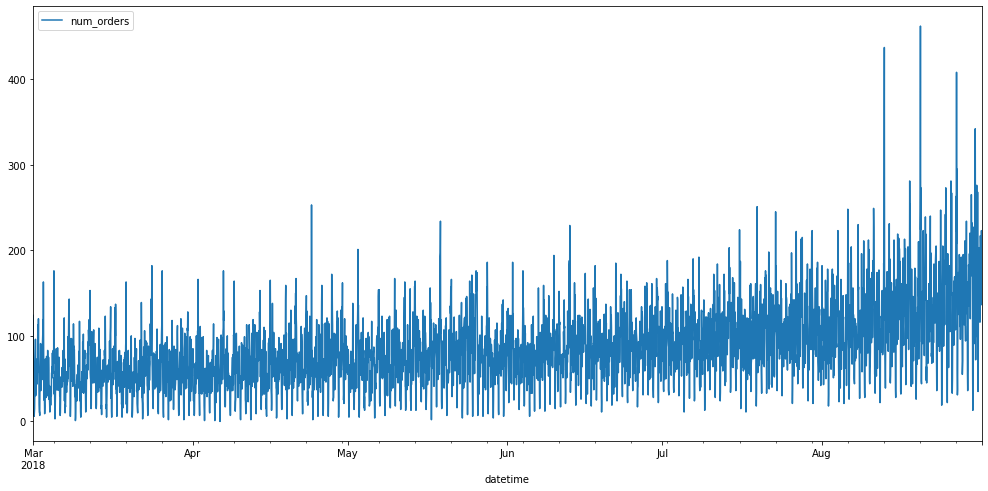

In [8]:
data.plot(figsize=(17, 8))

<AxesSubplot:xlabel='datetime'>

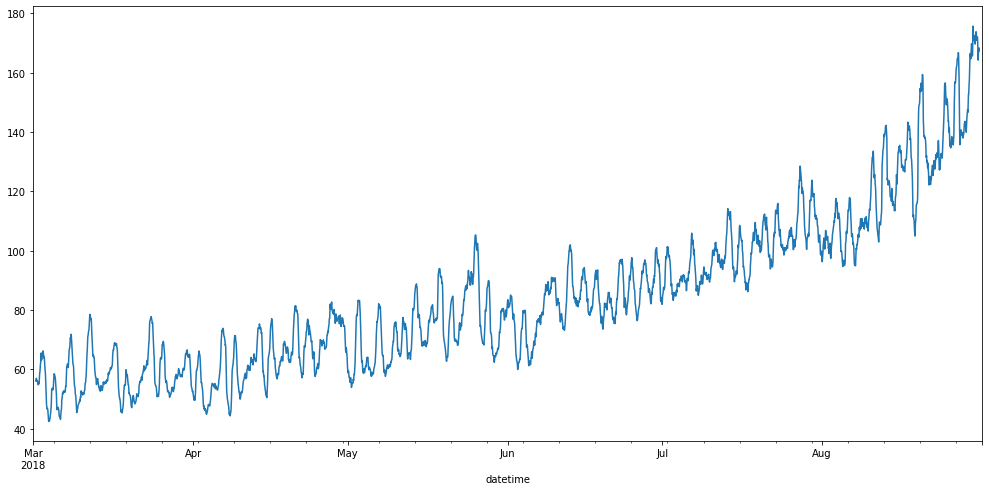

In [8]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=(17, 8))

<AxesSubplot:xlabel='datetime'>

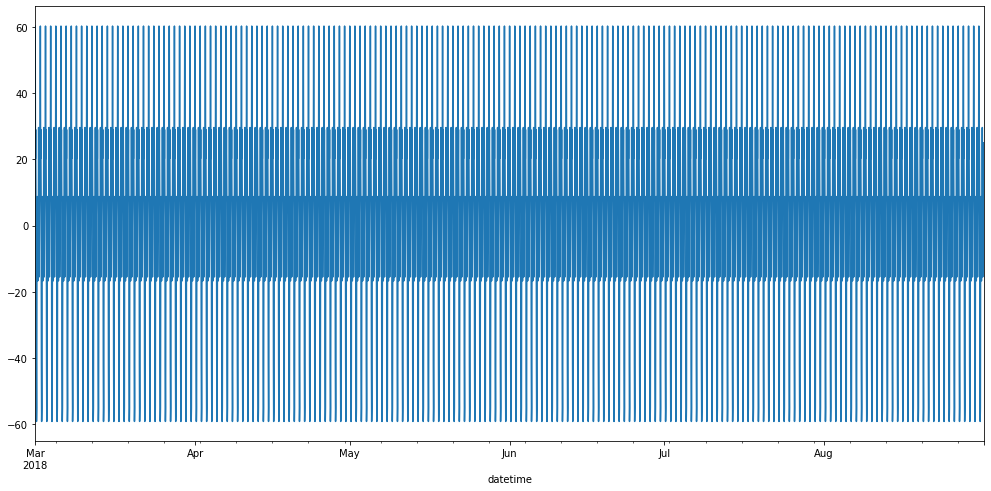

In [9]:
decomposed_data.seasonal.plot(figsize=(17, 8))

<AxesSubplot:xlabel='datetime'>

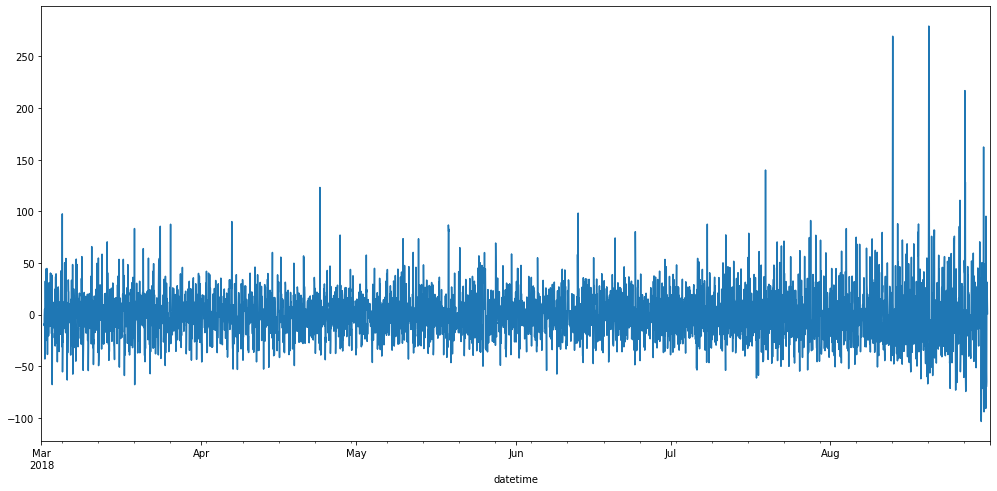

In [10]:
decomposed_data.resid.plot(figsize=(17, 8))

Посмотрим также на сезонность и тренды в рамках одной недели.

<AxesSubplot:xlabel='datetime'>

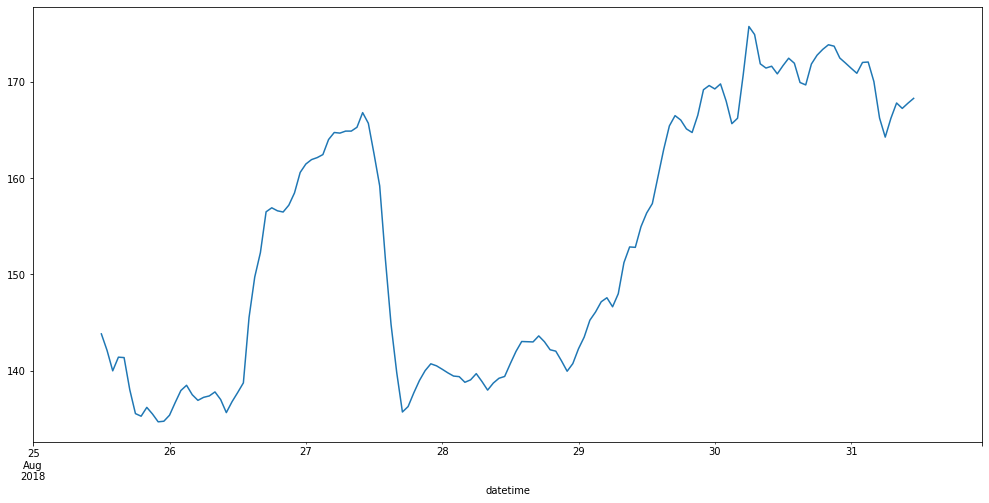

In [11]:
decomposed_data_week = seasonal_decompose(data['2018-08-25':'2018-08-31'])
decomposed_data_week.trend.plot(figsize=(17, 8))

<AxesSubplot:xlabel='datetime'>

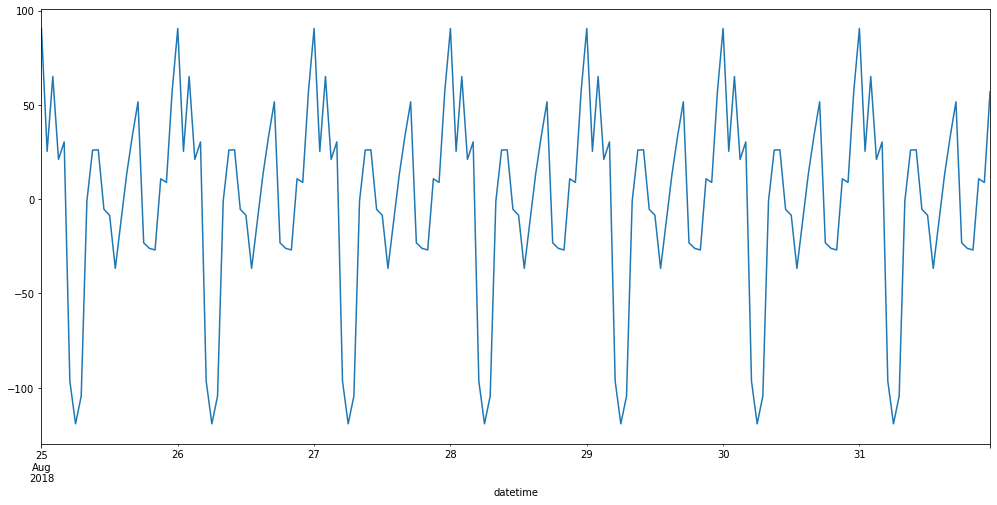

In [12]:
decomposed_data_week.seasonal.plot(figsize=(17, 8))

<AxesSubplot:xlabel='datetime'>

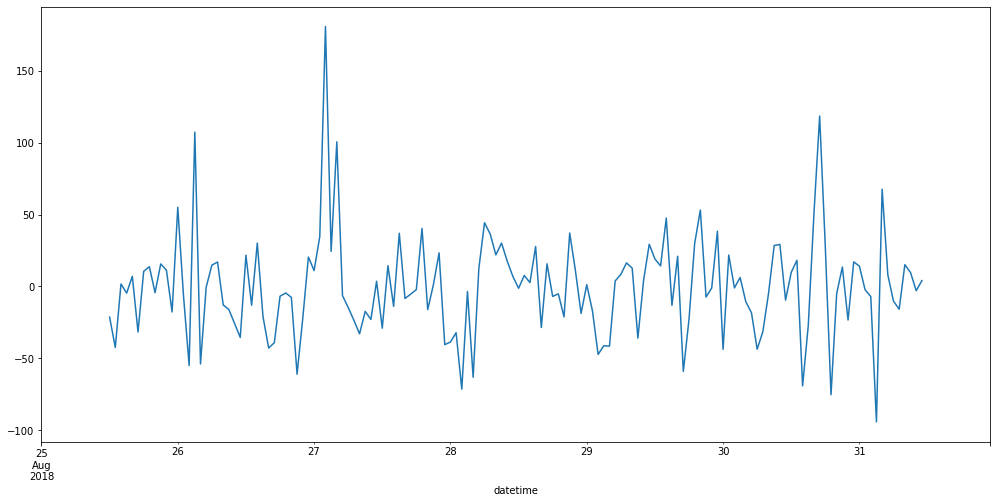

In [13]:
decomposed_data_week.resid.plot(figsize=(17, 8))

Из общего графика тренда видно, что со временем больше людей начинают пользоваться такси.
Следовательно, ряд не стационарный (подвержен тренду, который меняется во времени).
Признаки, которые нам потребуются для обучения модели:
- день (есть ежедневная сезонность)
- день недели (из графика тренда в последней неделе видно, что есть зависимость от дня недели)
- месяц 
- в качестве максимального лага возьмем 168 - количество часов в неделе
- в качестве окна - 30 (не знаю, как разумно выбрать какое-то число, поэтому взял относительно случайное)

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(data, 2, 24)

In [11]:
data.head(30)

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,NaN
2018-03-01 07:00:00,15,7,3,12.0,6.0,NaN
2018-03-01 08:00:00,34,8,3,15.0,12.0,NaN


## Обучение

Попробуем обучить следующие модели:
- линейная регрессия
- случайное дерево
- CatBoostRegressor
- LGBMRegressor

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

### Линейная регрессия

In [13]:
%%time

model_reg = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model_reg, features_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()*(-1))

Значение метрики RMSE на обучающей выборке для LinearRegression 31.399564096363022
CPU times: user 42.8 ms, sys: 3.65 ms, total: 46.5 ms
Wall time: 45 ms


### Случайное дерево

In [14]:
%%time

model_tree = DecisionTreeRegressor(random_state=12345)
max_depth_list = [x for x in range(2, 31)]
parameters_tree = {'max_depth': max_depth_list}
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_tree, param_grid = parameters_tree, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_
grid.best_score_*(-1)

CPU times: user 2.24 s, sys: 9.33 ms, total: 2.25 s
Wall time: 2.25 s


27.45448126747271

### CatBoostRegressor

In [30]:
%%time

model_cat = CatBoostRegressor(cat_features=[], verbose=False, random_state=12345)
parameters_cat = {'learning_rate':[0.1, 0.5, 0.8, 1]}
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_cat, parameters_cat, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
display(grid.best_params_)
display(grid.best_score_*(-1))

{'learning_rate': 0.1}

25.126299211829135

CPU times: user 38.1 s, sys: 3.04 s, total: 41.1 s
Wall time: 1min 8s


### LGBM Regressor

In [15]:
%%time

model_lgbm = LGBMRegressor(random_state=12345)
parameters_lgbm = {'num_leaves' : [100, 150, 200]}
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_lgbm, parameters_lgbm, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
display(grid.best_params_)
display(grid.best_score_*(-1))

{'num_leaves': 100}

24.982565682173473

CPU times: user 5min 36s, sys: 6.59 s, total: 5min 43s
Wall time: 5min 45s


По результатам анализа моделей лучший результат на тренировочной выборке показал LGBM Regressor, CatBoostRegressor показал достаточно близкий к нему результат, а дерево решений и линейная регрессия были сильно хуже.
На тестовой выборке будем проверять первые две модели.

## Тестирование

### LGBM Regressor

In [15]:
%%time

model_lgbm = LGBMRegressor(random_state=12345, num_leaves=100)
model_lgbm.fit(features_train, target_train)
pred_lgbm = model_lgbm.predict(features_test)
print('RMSE тестовой выборки для LGBM Regressor:', mean_squared_error(target_test, pred_lgbm)**0.5)

RMSE тестовой выборки для LGBM Regressor: 45.021799131094355
CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 1.97 s


Text(0, 0.5, 'Число заказов')

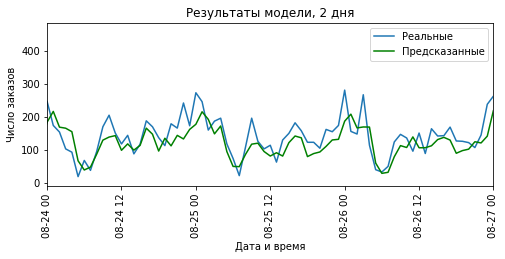

In [23]:
predictions = pd.Series(pred_lgbm)
predictions.index = target_test.index
#data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M')

fig2, ax = plt.subplots(figsize=(8, 3))
ax = sns.lineplot(data=target_test, label='Реальные')
sns.lineplot(data=predictions, color='green', label='Предсказанные')
plt.xticks(rotation=90)
#ax.set_xticklabels(features_test.dayofweek)
ax.set_xlim([pd.to_datetime('2018-08-24', format = '%Y-%m-%d'),
             pd.to_datetime('2018-08-27', format = '%Y-%m-%d')])
#plt.xlim('2018-08-24', '2018-08-27')
plt.title('Результаты модели, 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

## Общие выводы

В рамках этого проекта мы работали с временным рядом, создавали новые признаки для обучения модели, тестировали разные модели для поставленной задачи.

Лучший результат показала модель LGBM Regressor, ее RMSE на тестовой выборке составил 45.02, что является достаточным результатом для задачи.
Таким образом, именно эту модель я рекомендую использовать для решения задачи.